In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten,\
                                    Reshape, MaxPooling1D,\
                                    Dropout, Conv1DTranspose, UpSampling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from pyfaidx import Fasta
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
def encode_sequence(seq):
    
    d = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1], 
    'N' : [0.25, 0.25, 0.25, 0.25]}

    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')

In [3]:
data = pd.read_csv("VAE-Fetal-Adult.txt", sep="\t", header=0)
data.head()

,chrom,start,stop,rDHS,fetal,adult,shared
0,chr1,181289,181639,EH38D4327525,0,0,1
1,chr1,191294,191644,EH38D4327540,0,0,1
2,chr1,267925,268171,EH38D4327544,0,1,0
3,chr1,586036,586264,EH38D4327554,0,1,0
4,chr1,605330,605668,EH38D4327560,0,1,0


In [4]:
cells = data.columns[4:].tolist()
print(cells)
y_class = data[cells].values

['fetal', 'adult', 'shared']


In [5]:
print(cells)

['fetal', 'adult', 'shared']


In [6]:
latent_dim = 256
# filters = 128
# kernel_size = 32
# layer_filters = [128, 128]

In [7]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

def kl_divergence_loss(inputs):
    mu, log_var = inputs
    outputs = -0.5 * (1 + log_var - tf.math.square(mu) - tf.math.exp(log_var))
    return(outputs)

In [8]:
from tensorflow.keras.optimizers import Adam
def vae1():
    l = 512
    img = Input(shape = (l, 4))
    encoder = img
    
    encoder = Conv1D(filters=256, 
                     name="conv",
               kernel_size=32,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(8)(encoder)
    
    encoder = Conv1D(filters=128,
               kernel_size=8,
               activation='relu',
               strides=1,
               padding='same')(encoder)
    
    encoder = MaxPooling1D(2)(encoder)
    shape = K.int_shape(encoder)
    
    encoder = Flatten()(encoder)
    encoder = Dense(1028)(encoder)
    encoder = Dense(512)(encoder)
    
    
    # Define output latent space
    z_mu = tf.keras.layers.Dense(latent_dim, name = 'z_mu')(encoder)
    z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(encoder)
    z = tf.keras.layers.Lambda(sample_latent_features, name = 'latent_features')([z_mu, z_log_var])
    
    # Kullback-Leibler Divergence
    kl_div= tf.keras.layers.Lambda(kl_divergence_loss, name = 'kl_div')([z_mu, z_log_var])

    # Classifier
    classifier = tf.keras.layers.Dense(3, 
                                       activation = 'sigmoid', 
                                       name = 'classifier')(z)
    
    # latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    decoder = Dense(512)(z)
    decoder = Dense(1028)(decoder)
    decoder = Dense(shape[1] * shape[2])(decoder)
    decoder = Reshape((shape[1], shape[2]))(decoder)
    decoder = UpSampling1D(size=2)(decoder)
    decoder = Conv1DTranspose(128, kernel_size=8, strides=1, padding="same")(decoder)
    decoder = UpSampling1D(size=8)(decoder)
    decoder = Conv1DTranspose(l, kernel_size=32, strides=1, padding="same")(decoder)
    decoder = Conv1DTranspose(filters=4,
                              kernel_size=32,
                              activation='relu',
                              padding='same',
                              name='decoder')(decoder)
    
    vae_model = tf.keras.Model(img, [z_mu, z_log_var, z, kl_div, decoder, classifier])
    vae_model.summary()
    return(vae_model)

In [9]:
vae_model = vae1()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 4)]     0           []                               
                                                                                                  
 conv (Conv1D)                  (None, 512, 256)     33024       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 256)      0           ['conv[0][0]']                   
                                                                                                  
 conv1d (Conv1D)                (None, 64, 128)      262272      ['max_pooling1d[0][0]']          
                                                                                              

2023-12-28 16:54:10.338470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 16:54:12.167627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [10]:
# losses = {
#     "kl_div": "mean_absolute_error",
#     "classifier": "binary_crossentropy",
#     "decoder": "mean_squared_error",
# }

losses = {
    "kl_div": "mean_absolute_error",
    "classifier": "categorical_crossentropy",
    "decoder": "mean_squared_error",
}

loss_weights = {"kl_div": 1.0,
                "classifier" : 1.0,
               "decoder": 1.0}


vae_model.compile(optimizer=Adam(.0001), loss = losses, loss_weights=loss_weights)

In [11]:
genomeFasta = "/home/gregory.andrews-umw/data/genome/hg38.fa"
genome = Fasta(genomeFasta, sequence_always_upper=True, as_raw=True)
seqs = []
for index, row in data.iterrows():
    chrom, start, stop = row["chrom"], row["start"], row["stop"]
    center = (start + stop) // 2
    seqs.append(genome[chrom][center-256:center+256])

In [12]:
with Pool(8) as p:
    X = p.map(encode_sequence, seqs)

In [13]:
X = np.stack(X, axis=0)

In [14]:
X.shape

(361844, 512, 4)

In [15]:
y_kl = np.zeros(X.shape[0])
y_class = data[cells].values

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("Fetal-Adult-{epoch:02d}.hdf5", 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto',
                             period=1)

In [36]:
vae_model.fit(X, {'decoder': X, 
                  'kl_div': y_kl,
                  "classifier" : y_class},
              epochs=20, callbacks = [checkpoint], 
              validation_split = 0.1)

Epoch 1/20


2023-12-21 09:02:38.541068: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


10177/10177 [==============================] - ETA: 0s - loss: 1.2320 - kl_div_loss: 0.0293 - decoder_loss: 0.1863 - classifier_loss: 1.0165
Epoch 1: saving model to Fetal-Adult-01.hdf5
10177/10177 [==============================] - 194s 17ms/step - loss: 1.2320 - kl_div_loss: 0.0293 - decoder_loss: 0.1863 - classifier_loss: 1.0165 - val_loss: 1.1258 - val_kl_div_loss: 0.0229 - val_decoder_loss: 0.1857 - val_classifier_loss: 0.9172
Epoch 2/20
10175/10177 [============================>.] - ETA: 0s - loss: 1.0863 - kl_div_loss: 0.0284 - decoder_loss: 0.1859 - classifier_loss: 0.8721
Epoch 2: saving model to Fetal-Adult-02.hdf5
10177/10177 [==============================] - 173s 17ms/step - loss: 1.0863 - kl_div_loss: 0.0284 - decoder_loss: 0.1859 - classifier_loss: 0.8720 - val_loss: 1.0510 - val_kl_div_loss: 0.0307 - val_decoder_loss: 0.1860 - val_classifier_loss: 0.8342
Epoch 3/20
10175/10177 [============================>.] - ETA: 0s - loss: 1.0355 - kl_div_loss: 0.0315 - decoder_loss

In [17]:
vae_model.load_weights("Fetal-Adult-14.hdf5")

In [18]:
output = vae_model.predict(X)

2023-12-28 16:54:51.399982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [19]:
output[0].shape

(361844, 256)

In [20]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# u = umap.UMAP().fit_transform(output[0])
pca = PCA(n_components=64).fit_transform(output[0])
u = umap.UMAP().fit_transform(pca)

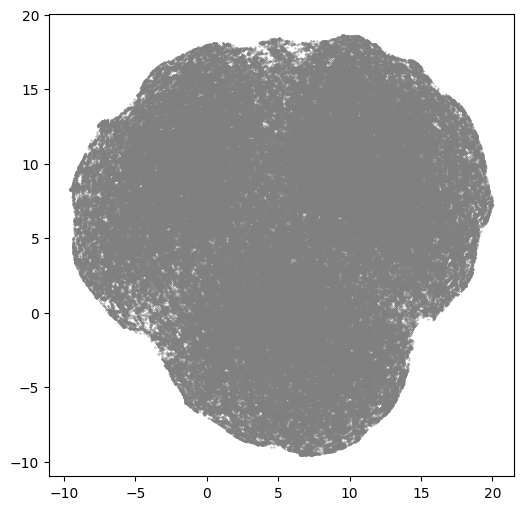

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(u[:,0], u[:,1], s=.1, color="gray")

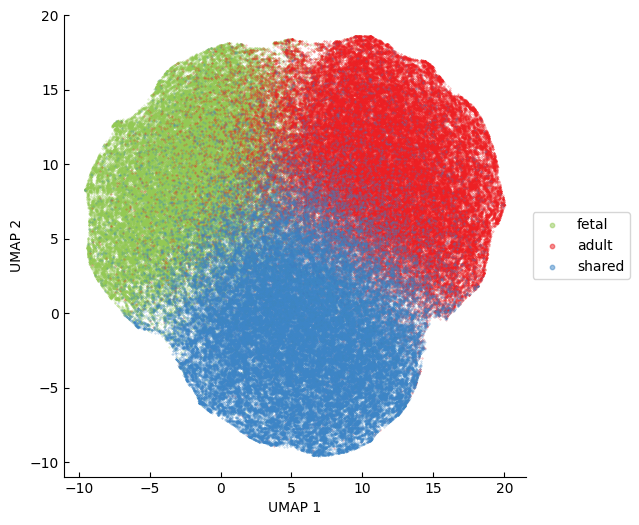

In [24]:
colors = {"adult" : "#ED2024",
          "fetal" : "#93C954", 
          "shared" : "#3D85C6"}

fig, ax = plt.subplots(figsize=(10,6))
for cell in cells:
    indices = data.index[(data[cell] == 1)]
    ax.scatter(u[indices,0], u[indices,1], s=.1, 
               label=cell, 
               alpha=0.5, color=colors[cell])

ax.set_box_aspect(1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.savefig("VAE-Fetal-Adult.pdf")
plt.savefig("VAE-Fetal-Adult.png")

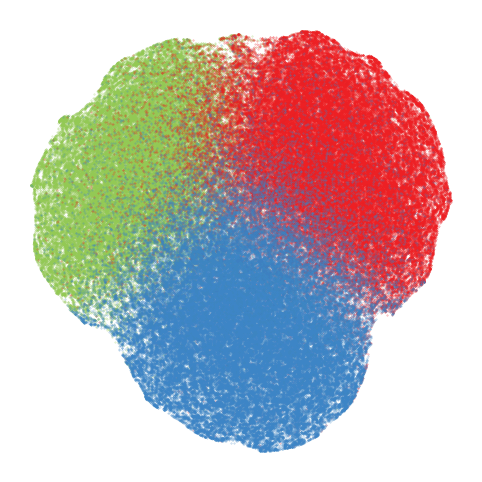

In [27]:
colors = {"adult" : "#ED2024",
          "fetal" : "#93C954", 
          "shared" : "#3D85C6"}

fig, ax = plt.subplots(figsize=(10,6))
for cell in cells:
    indices = data.index[(data[cell] == 1)]
    ax.scatter(u[indices,0], u[indices,1], s=.1, 
               label=cell, 
               alpha=0.5, color=colors[cell])

ax.set_box_aspect(1)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(bottom = False, left=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
# plt.savefig("VAE-Fetal-Adult.pdf")
plt.savefig("VAE-Fetal-Adult-Blobs.png")